In [1]:
import anndata 
import scanpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_cluster_scdata(scdata,cmap,all_clusters,clusters=[1,2],bg_color = 'gray',bg_pt_size = 5, point_sz_map = None, transpose=1,flipx=1,flipy=1,hue_input = 'leiden' , ax = None,use_seaborn = False,show_title = True):
    """
    plot spatial location of cell cluster using either seaborn or matplotlib
    use seaborn for individual clusters
    use matplotlib scatter function to visualize all clusters
    cmap - dictionary that has color of each cluster  used in umap
    """
    fig = None
    if not ax:
     fig,ax = plt.subplots(figsize=(15, 15),)# facecolor="black")

    
    if use_seaborn:
        x,y,hue = 'x', 'y',hue_input
        sns.scatterplot(x=x, y=y, data=scdata.obs, 
                        s=bg_pt_size, markers=dict(marker_edge_color='none'),
                        rasterized=True,
                        ax=ax,c= bg_color)
    else: # use matplotlib
        x,y = (np.array(scdata.obs[['x', 'y']])*[flipx,flipy])[:,::transpose].T
        ax.scatter(x, y, c=bg_color, s = bg_pt_size, marker='.')
        
    for cluster in clusters:
        clst_idx = all_clusters.index(cluster)
        cluster_ = str(cluster)
        inds = scdata.obs[hue_input] == cluster_
        
        #col = cmap[int(clst_idx) % len(cmap)]
        col = cmap[cluster_] # cmap is dictionary
        point_sz = point_sz_map[cluster_] # point size dictionary
        if use_seaborn:
            sns.scatterplot(x=x, y=y, data=scdata.obs[inds], 
                        s=point_sz, markers=dict(marker_edge_color=col),
                        rasterized=True,
                        ax=ax,c= col)
            if show_title:
                ax.set_title(f'cluster {cluster_}',fontsize = 7, y= 1)
        else:
            x_ = x[inds]
            y_ = y[inds]
            ax.scatter(x_, y_, c=col, s= point_sz, marker='.',label = cluster_)
        
        
    
    # ax.set_xlim([x.min(),x.max()])
    # ax.set_ylim([y.min(),y.max()])
    ax.grid(False)
    ax.axis("off")
    ax.axis("equal")
    if fig:
        ax.legend( loc = 'lower center', ncol = len(clusters)//3,markerscale = 12, title = 'Clusters',facecolor = 'black',
            labelcolor = 'white')
        ax.set_title(np.unique(scdata.obs['sample'])[0])
    else:
        # ax.legend( loc = 'lower center')
        pass
        
    ax.autoscale(enable=True, tight=True)
    
   

- Load in the adata

In [ ]:
# load 1311 posterior 
adata  = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER2_Gpe_Gpi_CaPu_1311__MERFISH_annotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'./../../spatialDomain_analysis/processed_data/donor_1311_PosteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
adata.obs = adata.obs.join(spatialModuleAnnotation[['Final_Major_region_label','MatrixStriosome_label']])


In [5]:
common_gns = np.array(adata.var_names)
adata.X = adata.layers['X_raw']
adata = adata[:,common_gns].copy()
adata.obsm['X_spatial'] = adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in adata.obsm else adata.obsm['X_spatial']


- Get the Figure size based on the tissue  dimension

In [6]:
def rotate(spatial_x,deg):
    """
    spatial_X: Nx2 matrix
    deg: rotation degree in radian
    
    """
    deg = np.deg2rad(deg)
    rotation_mat = np.array([[np.cos(deg),-1*np.sin(deg)],
                            [np.sin(deg),np.cos(deg)]])
    return np.matmul(spatial_x,rotation_mat)

In [7]:
cluster_cmap = np.load(r'./cluster_cmap_final_updated_9172025.npy', allow_pickle=True).item()
all_clusters = np.unique(adata.obs['Group_name']).tolist()
clusters_curated = [ 

# +++++++++++++ Oligo +++++++++++++++++++++++
'ImOligo','Oligo OPALIN', 'Oligo PLEKHG1',
'COP',
'OPC',
 
# # glia (Astro-Ependy-Immune)
 'Astrocyte',
  'Ependymal',
  'ImAstro',
 'B cells',
 'BAM',
 'Endo',
'VLMC',
'Pericyte',
 'SMC',

# # # ++++++++++++++++ Gp cells  +++++++++++++++++++
 'GPe MEIS2-SOX6 GABA',
 'GPe SOX6-CTXND1 GABA',
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
 'GPi Core',
 'GPi Shell',
 'GPin-BF Cholinergic GABA',

# # +++++++++++++++++ MSN ++++++++++++++++++++++++++++++++
    'STR D1D2 Hybrid MSN',
    'STRd D2 StrioMat Hybrid MSN',
    'STRv D1 NUDAP MSN',
    'STRd D2 Striosome MSN',
    'STRd D2 Matrix MSN',
    'STRd D1 Striosome MSN',
    'STRd D1 Matrix MSN',
    'STRv D2 MSN',
    'STRv D1 MSN',
    
    

    ]

remaining_clusters  = list(set(all_clusters).difference(clusters_curated))

all_clusters = remaining_clusters + clusters_curated
point_sz_map = { 'Oligo OPALIN': 0.2,
                 'Oligo PLEKHG1': 0.5,
                  'COP':0.5,
                  'ImOligo':0.2,
                  'OPC': 0.5,
                'STR D1D2 Hybrid MSN': 2,
                'STRd D2 StrioMat Hybrid MSN': 2,
                'STRv D1 NUDAP MSN':2,
                 'STRd D2 Striosome MSN':1,
                 'STRd D1 Striosome MSN':1,
                 'STRd D2 Matrix MSN':2,
                 'STRd D1 Matrix MSN':2,
                 'STRv D1 MSN':2,
                 'STRv D2 MSN':2,
                  'GPi Core':4,
                  'GPi Shell':4,
                   'GPe SOX6-CTXND1 GABA':2,
                   'GPe MEIS2-SOX6 GABA':2,
                   'GPe-NDB-SI LHX6-LHX8-GBX1 GABA':2,
                    'GPin-BF Cholinergic GABA':2,
                   
                    # glia (Astro-Ependy-Immune)
                    'Astrocyte':0.2,
                    'Ependymal':0.2,
                    'ImAstro':0.2,
                    'B cells':0.2,
                    'BAM':0.2,
                    'Endo':0.2,
                    'VLMC': 1,
                     'Pericyte': 0.5,
                     'SMC': 1

                    
                 }

point_sz_map.update({clst:3 for clst in remaining_clusters})

In [8]:
import seaborn as sns
import matplotlib.patches as patches
import os
rot_deg = {'Donor_1311_posterior':0, 'Donor_2427_anterior':-45,'Donor_2427_posterior':0,'Donor_3924_anterior':45} # rotation value for each sample 

adata.obs[['x','y']] = adata.obsm['X_spatial'].copy()
figsize_scale = 8e3
sample = 'Donor_1311_posterior'

# adjucent the spatial coordinate 
X_sample = adata.obsm['X_spatial'].copy()
X_sample = rotate(X_sample,rot_deg[sample]) # since rotation is could change the xy limit, perform rotation to get accurate estiamte

# idenity the proprotion betwen the width and height of the sample
dx,dy = np.abs(np.ptp(X_sample, axis = 0))
dx = dx/figsize_scale
dy = dy/figsize_scale


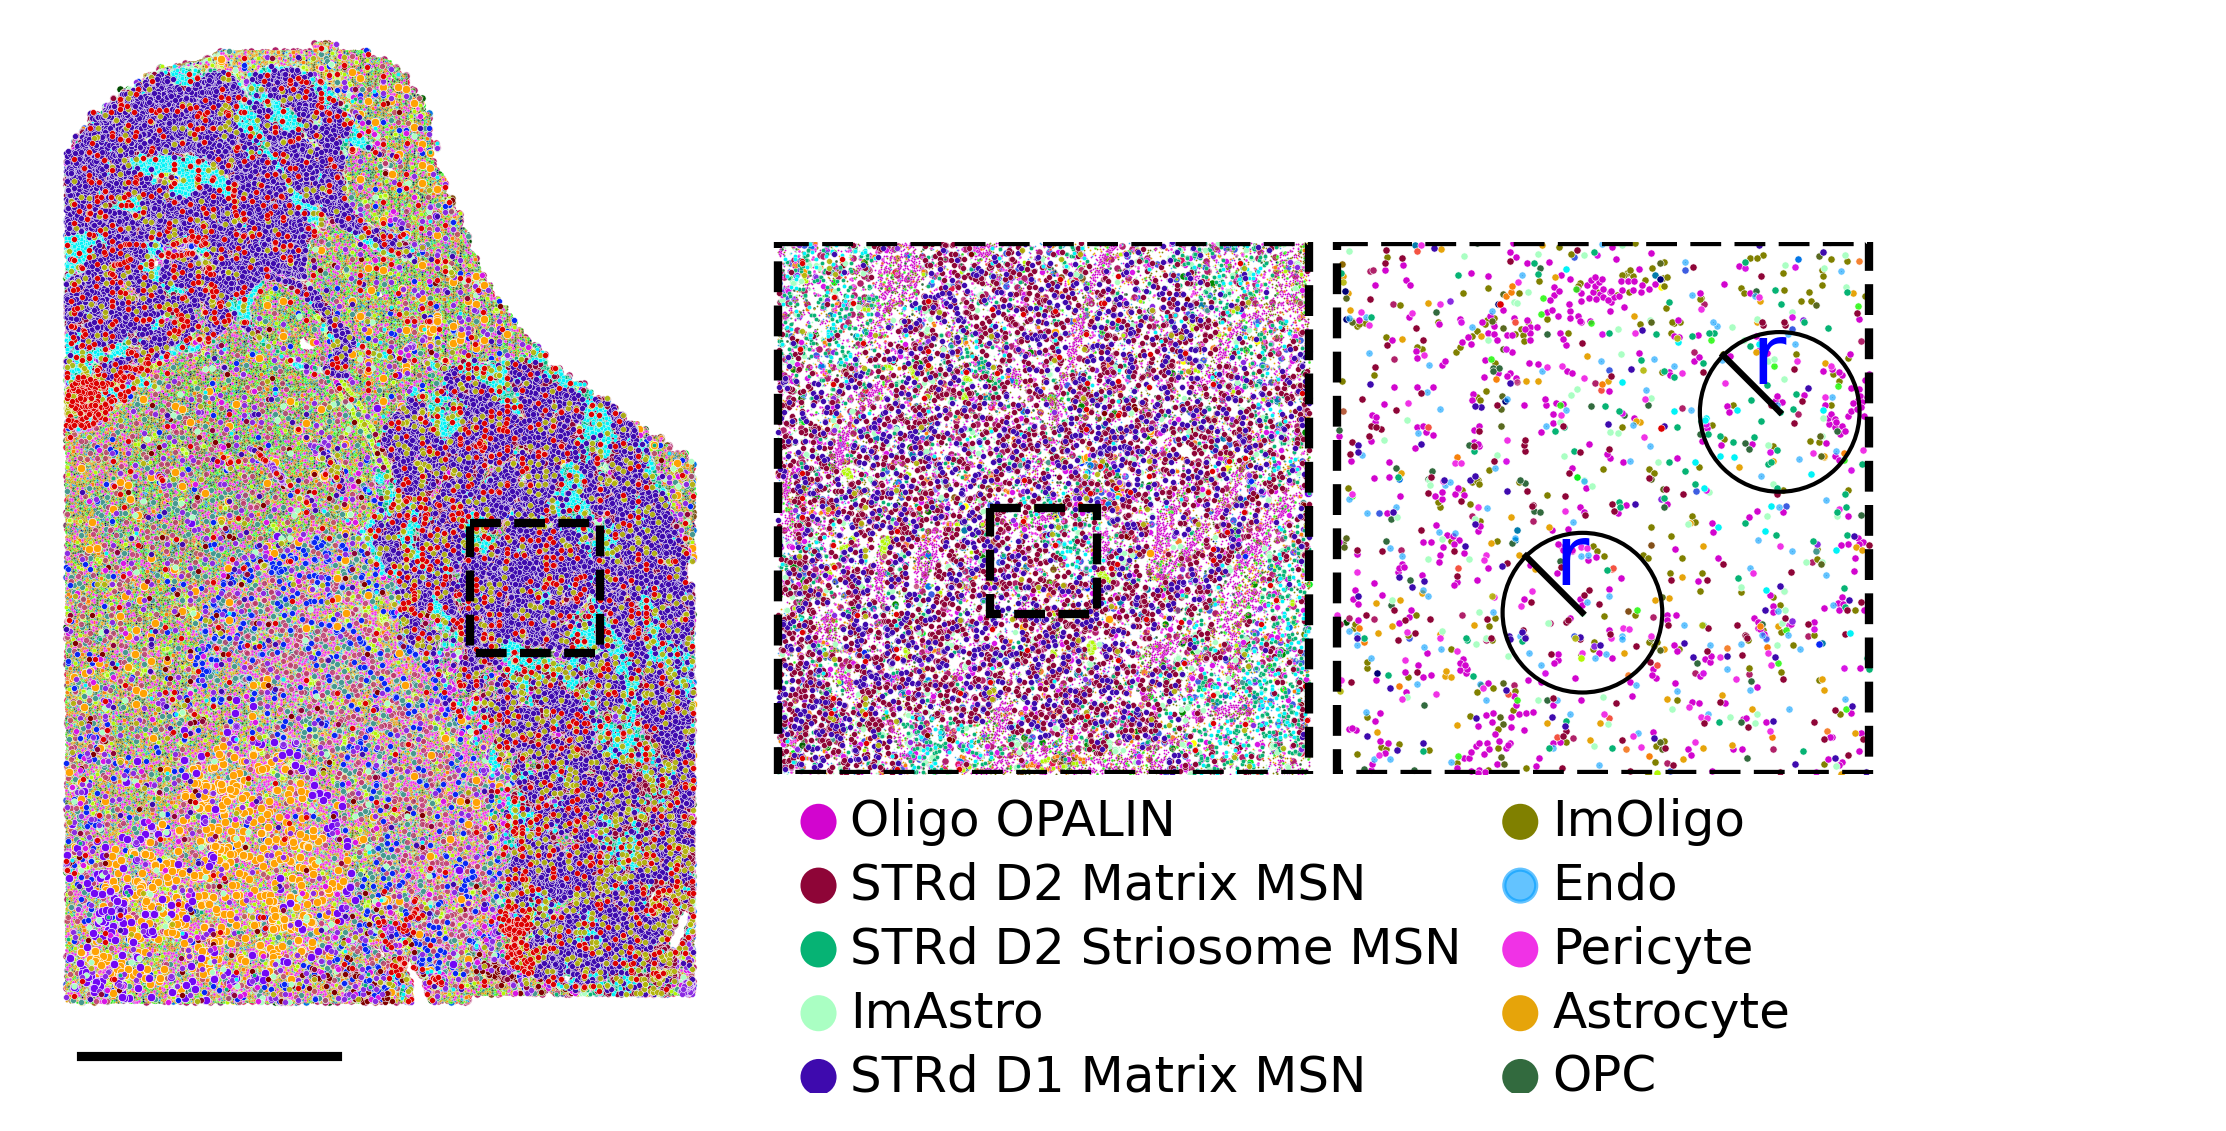

In [ ]:
import matplotlib.patches as patches
import copy
notext_nobox = False

fig,ax = plt.subplots(1,1, dpi = 300, figsize = (dx,dy))
# sns.scatterplot(x = adata.obsm['X_spatial'][:,0],y = adata.obsm['X_spatial'][:,1], s = 0.051, ax = ax)
plot_cluster_scdata(adata,cluster_cmap,all_clusters = all_clusters,clusters = all_clusters,bg_color = 'gray',bg_pt_size = 0.05, point_sz_map = point_sz_map, transpose=1,flipx=1,flipy=1,hue_input = 'Group_name' , ax = ax,use_seaborn = True,show_title = False )

# add zoom-in bbox 
zoom_box = patches.Rectangle([3000,500],5000,5000, fill = False, color = 'k', ls = '--',lw = 2)
if not notext_nobox:
    ax.add_patch(zoom_box)
ax.invert_yaxis()
# ax.set_axis_off()

# Add panel for zoom in 
bbox = ax.get_position()
zoom_ax1 = fig.add_axes([bbox.xmin + 0.95*bbox.width, bbox.ymin + 0.3*bbox.height, bbox.width, 0.5*bbox.height ])
zoom_ax2 = fig.add_axes([bbox.xmin + 1.75*bbox.width, bbox.ymin + 0.3*bbox.height , bbox.width, 0.5*bbox.height ])

# plot the first zoom in 
cond1 = (adata.obsm['X_spatial'][:,0] > 3000) & (adata.obsm['X_spatial'][:,0] < 8000)
cond2 = (adata.obsm['X_spatial'][:,1] > 500) & (adata.obsm['X_spatial'][:,1] < 5500)
# sns.scatterplot(x = adata.obsm['X_spatial'][cond1 & cond2,0],y = adata.obsm['X_spatial'][cond1 & cond2,1], s = 0.51, ax = zoom_ax1)
plot_cluster_scdata(adata[cond1 & cond2],cluster_cmap,all_clusters = all_clusters,clusters = all_clusters,bg_color = 'gray',bg_pt_size = 0.05, point_sz_map = point_sz_map, transpose=1,flipx=1,flipy=1,hue_input = 'Group_name' , ax = zoom_ax1,use_seaborn = True,show_title = False )

# add zoom in to the second panel 
zoom_box2 = patches.Rectangle([5000,3000],1000,1000, fill = False, color = 'k', ls = '--',lw = 2)
if not notext_nobox:
    zoom_ax1.add_patch(zoom_box2)

xmin, ymin = adata[cond1 & cond2].obsm['X_spatial'].min(axis=0)
width,height = np.ptp(adata[cond1 & cond2].obsm['X_spatial'],axis = 0) 
bbox_  = patches.Rectangle([xmin, ymin],width,height, fill = False, lw = 2, ls = '--')
if not notext_nobox:
    zoom_ax1.add_patch(bbox_)


zoom_ax1.invert_yaxis()
zoom_ax1.set_axis_off()

# plot the first zoom in 
cond1 = (adata.obsm['X_spatial'][:,0] > 5000) & (adata.obsm['X_spatial'][:,0] < 6000)
cond2 = (adata.obsm['X_spatial'][:,1] > 3000) & (adata.obsm['X_spatial'][:,1] < 4000)

# double the size of points
point_sz_map2 = copy.deepcopy(point_sz_map)
point_sz_map2 = {k:3 for k in point_sz_map2}
# for k,v in point_sz_map2.items():
#     point_sz_map2[k] = 0.8*v if v >1 else 5*v

# sns.scatterplot(x = adata.obsm['X_spatial'][cond1 & cond2,0],y = adata.obsm['X_spatial'][cond1 & cond2,1], s = 1, ax = zoom_ax2)
plot_cluster_scdata(adata[cond1 & cond2],cluster_cmap,all_clusters = all_clusters,clusters = all_clusters,bg_color = 'gray',bg_pt_size = 0.05, point_sz_map = point_sz_map2, transpose=1,flipx=1,flipy=1,hue_input = 'Group_name' , ax = zoom_ax2,use_seaborn = True,show_title = False )

xmin, ymin = adata[cond1 & cond2].obsm['X_spatial'].min(axis=0)
width,height = np.ptp(adata[cond1 & cond2].obsm['X_spatial'],axis = 0) 
bbox_  = patches.Rectangle([xmin, ymin],width,height, fill = False, lw = 2, ls = '--')
if not notext_nobox:
    zoom_ax2.add_patch(bbox_)

zoom_ax2.set_axis_off()
zoom_ax2.invert_yaxis()

# pick a point and plot a circle, pick 3 cells at 3 distinict location, 
xcoord =  adata.obsm['X_spatial'][cond1 & cond2,0] 
ycoord =  adata.obsm['X_spatial'][cond1 & cond2,1] 

cell1 = adata[cond1 & cond2].obs_names[xcoord > np.percentile(xcoord,80)][10]
cell2 = adata[cond1 & cond2].obs_names[xcoord > np.percentile(ycoord,40)][400]

# plot circle centered at  cell 
cell1_circle = patches.Circle(tuple(adata[cell1,:].obsm['X_spatial'].squeeze()), 150, fill = False)
zoom_ax2.add_patch(cell1_circle)
# add arrow 
pt2 = np.array(adata[cell1,:].obsm['X_spatial']) + 150*np.array([[-1*np.cos(np.pi/4),-1*np.sin(np.pi/4)]])
pt1 = np.array(adata[cell1,:].obsm['X_spatial'])
pts = np.vstack([pt1,pt2])
pt2 = np.array(adata[cell1,:].obsm['X_spatial']) + 75*np.array([[-1*np.cos(np.pi/4),-1*np.sin(np.pi/4)]])
if not notext_nobox:
    zoom_ax2.text(*tuple(np.squeeze(pt2)),'r',fontsize = 20,color = 'b')

zoom_ax2.plot(pts[::-1,0],pts[::-1,1], c = 'k')

# plot the circle center at cell #2
cell2_circle = patches.Circle(tuple(adata[cell2,:].obsm['X_spatial'].squeeze()), 150, fill = False)

zoom_ax2.add_patch(cell2_circle)
pt2 = np.array(adata[cell2,:].obsm['X_spatial']) + 150*np.array([[-1*np.cos(np.pi/4),-1*np.sin(np.pi/4)]])
pt1 = np.array(adata[cell2,:].obsm['X_spatial'])
pts = np.vstack([pt1,pt2])

zoom_ax2.plot(pts[:,0],pts[:,1], c = 'k')
zoom_ax2.set_aspect('equal', adjustable = 'datalim')
# add text to label the radius 
pt2 = np.array(adata[cell2,:].obsm['X_spatial']) + 75*np.array([[-1*np.cos(np.pi/4),-1*np.sin(np.pi/4)]])
if not notext_nobox:
    zoom_ax2.text(*tuple(np.squeeze(pt2)),'r', fontsize = 20,color = 'b')

# add axis to show the legend for cell types

bbox = ax.get_position()
legend_ax = fig.add_axes([bbox.xmin + 1.1*bbox.width, bbox.ymin, 2*bbox.width, 0.3*bbox.height ])

unq_clusters, unq_clusters_ct = np.unique(adata[cond1 & cond2].obs['Group_name'], return_counts = True)

cluster_ = unq_clusters[np.argsort(unq_clusters_ct)[::-1]][:10]
for clst_i, clst in enumerate(cluster_):
    color_rec = patches.Circle([-1.63 + 2.2*(clst_i%2),0.85 - 0.2*(clst_i//2)],0.05, color = cluster_cmap[clst])
    legend_ax.add_patch(color_rec)
    legend_ax.text((-1.63 + 2.2*(clst_i%2)) + 0.1, 0.85 - 0.2*(clst_i//2) , f'{clst}', fontsize = 12, color = 'k', va = 'center')
legend_ax.set_aspect('equal',adjustable='datalim')
legend_ax.set_axis_off()
filename = 'communityAnalysis_schematics'
if notext_nobox:
    filename = filename + 'notextnobox'

xmax, ymax = X_sample.max(axis=0)
xmin, ymin = X_sample.min(axis=0)
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymax + 3500,ymin - 500])
scalebar = patches.Rectangle([xmin + 500,1*ymax + 2000],10000,200,color = 'k')

ax.add_patch(scalebar)

plt.savefig(r'./figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{filename}.png',bbox_inches = 'tight')
plt.savefig(r'./figures/GlobalSpatialModule_Focus_Figure' +  os.sep +  f'{filename}.tif',bbox_inches = 'tight')
# ax.set_axis_on()
plt.show()